## Tensorboard

In [1]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard

In [3]:
! del /q %TMP%\.tensorboard-info\*

The system cannot find the file specified.


In [2]:
%tensorboard --logdir logs/scalars --host localhost

In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline 
%matplotlib notebook
import sklearn
import skimage
from sklearn import svm, metrics, datasets
from sklearn.utils import Bunch
from sklearn.model_selection import GridSearchCV, train_test_split
from scipy import ndimage, misc

import os
# os.environ["CUDA_VISIBLE_DEVICES"]="0"
from skimage.transform import resize
import pylab
import pydicom as pyd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.preprocessing import image

import cv2

Using TensorFlow backend.


In [ ]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("physical_devices-------------", len(physical_devices))
# tf.config.experimental.set_visible_devices(physical_devices[0], 'GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
from skimage import exposure
def dcmchange(orig,clahe,mask) :
    r,c = orig.shape
    new = np.empty((r,c,3), dtype=orig.dtype)
#     new[:,:,:] = orig[:,:,np.newaxis]
    new[:,:,0] = orig[:,:]
    new[:,:,1] = clahe[:,:]
    new[:,:,2] = mask[:,:]
    return new

In [5]:
from skimage import measure, morphology, segmentation

def marker(img):
    h,w = img.shape[:2]
    for row in range(h):
        if img[row, 0] == 1:
            cv2.floodFill(img, None, (0, row), 0)
        if img[row, w-1] == 1:
            cv2.floodFill(img, None, (w-1, row), 0)
    for col in range(w):
        if img[0, col] == 1:
            cv2.floodFill(img, None, (col, 0), 0)
        if img[h-1, col] == 1:
            cv2.floodFill(img, None, (col, h-1), 0)
    holes = img.copy()
    cv2.floodFill(holes, None, (0,0), 1)
    holes = cv2.bitwise_not(holes)
    mask = cv2.bitwise_or(img, holes)
    mask_img = cv2.bitwise_and(img, img, mask=mask)
    return mask_img

## Read Data

In [9]:
p = Path("dataset/")
dirs = p.glob("*")
labels_dict = {'CA lung':0, 'Extra':0, 'Heart and TGV':0,
               'Intra': 0, 'No Finding': 1, 'TB': 0, 'Pneumonia' : 0}
count = 0

disease_images = []
normal_images = []
disease_labels = []
normal_labels = []

count_normal = 0
count_disease = 0

for folder_dir in dirs:
    label = str(folder_dir).split("\\")[-1][:-1]
#     print(label)
#     print(folder_dir)
    if label == 'Extra' or label == 'No Finding' :
        for img_path in folder_dir.glob("*.dcm"):
#             print(img_path)
#             pic = pyd.read_file(os.path.normpath(img_path))
            target = "./" + str(img_path)
#             print(target)
            pic = pyd.read_file(target)
    #         pic_dir.append(pic)
            pic_r = np.array(pic.pixel_array)
    #         print(pic_r.shape)
            %matplotlib inline 
    #         preprocessing
            clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8,8))
            pic_r1 = clahe.apply(pic_r)
            
            mark = marker(pic_r)
#             plt.imshow(mark)
#             print(mark.shape)
    #         preprocessing
            IMG_PX_SIZE = 224
            resized_org = resize(pic_r, (IMG_PX_SIZE, IMG_PX_SIZE), anti_aliasing=True)
            resized_clahe = resize(pic_r1, (IMG_PX_SIZE, IMG_PX_SIZE), anti_aliasing=True)
            resized_equal = exposure.equalize_adapthist(resized_org, clip_limit=0.03)
            #change pic to (224,224,3)
            resized_img = dcmchange(resized_org,resized_clahe,resized_equal)
            resized_img2 = exposure.equalize_adapthist(resized_img, clip_limit=0.03)

            if label == 'Extra' :
                disease_images.append(resized_img2)
                disease_labels.append(labels_dict[label])
#                 heart_images.append(ndimage.rotate(resized_img2, 1, reshape=False))
                count_disease+=1
            elif label == 'No Finding' :
                normal_images.append(resized_img2)
                normal_labels.append(labels_dict[label])
                count_normal+=1

            if count_normal == 200 or count_disease == 200 : 
                break

        count_normal = 0
        count_disease = 0


C:\Users\GhostLinER\Anaconda3\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


## Test/Train

In [10]:
disease_images = np.array(disease_images, dtype=np.float32) #heart_images
disease_labels = np.array(disease_labels)
normal_images = np.array(normal_images, dtype=np.float32) #normal_images
normal_labels = np.array(normal_labels)

In [11]:
print("number of sample Heart: {}".format(len(disease_images)))
print("number of sample No Finding: {}".format(len(normal_images)))

number of sample Heart: 200
number of sample No Finding: 200


In [74]:
disease_images[1][223,0]

array([0.03137255, 0.16078432, 0.03137255], dtype=float32)

In [6]:
disease_images[1].shape

(224, 224, 3)

In [7]:
np.max(disease_images[400])

IndexError: index 400 is out of bounds for axis 0 with size 100

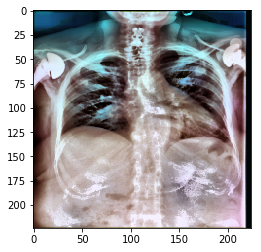

In [7]:
plt.imshow(disease_images[1])

In [29]:
img = disease_images[10]

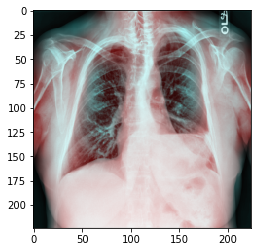

In [32]:
plt.imshow(img)

In [30]:
flip = cv2.flip(img, 1)

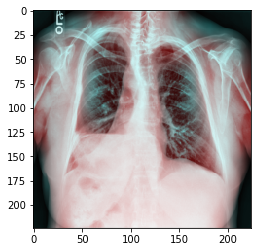

In [31]:
plt.imshow(flip)

## Feature

In [12]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from datetime import datetime
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
# from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, auc

# from tensorflow.keras.applications import VGG16

## Model

In [31]:
def cnn_model(X_train,y_train,X_test,y_test,X_val,y_val,r,text) :
    
    tf.keras.backend.clear_session()
    
    #tensorboard
    logdir = "logs\\scalars\\" + str(text) + "-Fold" + str(r) + "-" + datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
    
    INIT_LR = 1e-3
    EPOCHS = 30
    opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
    
    vgg_model = VGG16(weights="imagenet", 
                             include_top= False,
                             input_tensor=Input(shape=(224, 224,3)))
    
    for layer in vgg_model.layers:
        layer.trainable = False
        
    new_model = vgg_model.output
    new_model = AveragePooling2D(pool_size=(7, 7))(new_model)
    new_model = Flatten(name="flatten")(new_model)
    new_model = Dense(64, activation="relu")(new_model)
    new_model = Dropout(0.4)(new_model)
    new_model = Dense(2, activation="softmax")(new_model)
    model = Model(inputs=vgg_model.input, outputs=new_model)
    
#     model.summary()

    model.compile(optimizer=opt,
#               loss='categorical_crossentropy',
                loss='binary_crossentropy',
              metrics=['accuracy'])
#     with tf.device("/device:GPU:0"):
    history = model.fit(
        X_train, # input
        y_train, # output
        batch_size=16,
        verbose=0, # Suppress chatty output; use Tensorboard instead
        epochs=EPOCHS,
        validation_data=(X_val, y_val),
#         callbacks=[tensorboard_callback],
    )
    print("Average test accuracy: ", np.average(history.history['accuracy']))
    print("Average test loss: ", np.average(history.history['loss']))
    
    %matplotlib inline 
    
    plt.figure()
    plt.plot(history.history['accuracy'], 'orange', label='Training accuracy')
    plt.plot(history.history['val_accuracy'], 'blue', label='Validation accuracy')
    plt.plot(history.history['loss'], 'red', label='Training loss')
    plt.plot(history.history['val_loss'], 'green', label='Validation loss')
    plt.legend()
    plt.show()
    
    print("Path Test")
    y_pred = model.predict(X_val)
    y_pred_test = model.predict(X_test)
    
#     #confusion
    confusion(y_test,y_pred_test)
    print("Path Validate")
    confusion(y_val,y_pred)

    #roc
    fpr, tpr, thresholds = roc_curve(y_val[:,1], y_pred[:,1])
#     print(fpr)
    roc_auc = metrics.auc(fpr, tpr)
    
    #save model
    model.save('model\\extra\\vgg16\\'+str(text)+'_'+str(r))
    
    return fpr,tpr,roc_auc

In [32]:
from tensorflow.keras.applications import VGG19
def vgg19_model(X_train,y_train,X_test,y_test,X_val,y_val,r,text) :
    
    tf.keras.backend.clear_session()
    
    #tensorboard
    logdir = "logs\\scalars\\" + str(text) + "-Fold" + str(r) + "-" + datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
    
    INIT_LR = 2e-3
    EPOCHS = 20
    opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
    
    vgg19_model = VGG19(weights="imagenet", 
                             include_top= False,
                             input_tensor=Input(shape=(224, 224,3)))
    
    for layer in vgg19_model.layers:
        layer.trainable = False
        
    new_model = vgg19_model.output
    new_model = AveragePooling2D(pool_size=(7, 7))(new_model)
    new_model = Flatten(name="flatten")(new_model)
    new_model = Dense(64, activation="relu")(new_model)
    new_model = Dropout(0.4)(new_model)
    new_model = Dense(2, activation="softmax")(new_model)
    model = Model(inputs=vgg19_model.input, outputs=new_model)
    
#     model.summary()

    model.compile(optimizer=opt,
              loss='categorical_crossentropy',
#                 loss='binary_crossentropy',
              metrics=['accuracy'])
#     with tf.device("/device:GPU:0"):
    history = model.fit(
        X_train, # input
        y_train, # output
        batch_size=16,
        verbose=0, # Suppress chatty output; use Tensorboard instead
        epochs=EPOCHS,
        validation_data=(X_val, y_val),
#         callbacks=[tensorboard_callback],
    )
    print("Average test accuracy: ", np.average(history.history['accuracy']))
    print("Average test loss: ", np.average(history.history['loss']))
    
    %matplotlib inline 
    
    plt.figure()
    plt.plot(history.history['accuracy'], 'orange', label='Training accuracy')
    plt.plot(history.history['val_accuracy'], 'blue', label='Validation accuracy')
    plt.plot(history.history['loss'], 'red', label='Training loss')
    plt.plot(history.history['val_loss'], 'green', label='Validation loss')
    plt.legend()
    plt.show()
    
    print("Path Test")
    y_pred = model.predict(X_val)
    y_pred_test = model.predict(X_test)
    
    #confusion
    confusion(y_test,y_pred_test)
    print("Path Validate")
    confusion(y_val,y_pred)
    
    #roc
    fpr, tpr, thresholds = roc_curve(y_val[:,1], y_pred[:,1])
    roc_auc = metrics.auc(fpr, tpr)
    
    #save model
    model.save('model\\extra\\vgg19\\'+str(text)+'_'+str(r))
    
    return fpr,tpr,roc_auc

## Confusion Matrix

In [17]:
import seaborn as sns
from sklearn.metrics import classification_report 
def confusion(y_test,pred) :
    cm_plot_labels = ['Finding', 'Normal']
    #Confusion Matrix
    %matplotlib inline 

    confusion_mat1 = confusion_matrix(y_test.argmax(axis=1), pred.argmax(axis=1))
    confusion_mat1 = confusion_mat1.astype('float') / confusion_mat1.sum(axis=1)[:, np.newaxis]
    
#     plot_confusion_matrix(confusion_mat1, cm_plot_labels, title='Confusion Matrix')
    sns.heatmap(confusion_mat1, annot=True, fmt=".2f")
    plt.show()
    
    print(classification_report(y_test.argmax(axis=1), pred.argmax(axis=1), target_names=cm_plot_labels))
    

## ROC

In [18]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
# from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, auc

In [19]:
def sum_roc(set):
    output = []
    maximum = 0
    for lis in set:
        if len(lis) > maximum :
            maximum = len(lis)
    print("yeah")
    for i in range(maximum):
        temp = []
        for lis in set:
            if i < len(lis):
                temp.append(lis[i])
        output.append(np.mean(temp))
#     output = np.array(output)
    return output

In [20]:
def roc(fpr_recv,tpr_recv,acc_recv,num) :

    color = ["orange","green","blue","red","purple"]
    for i in range(num):
        fpr_use = fpr_recv[i]
        tpr_use = tpr_recv[i]
        acc_use = acc_recv[i]
#         print(len(fpr_use))
#         auc = roc_auc_score(y_val_rec, roc_pred)
#         print('AUC Fold %d: %0.4f' %(i,auc))
        
        plt.plot(fpr_use, tpr_use, color='{}'.format(color[i]), label='AUC Fold %d: %0.4f' %(i,acc_use))
        plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    std_auc = np.std(acc_recv)
    tprs = []
#     auc = []
    mean_fpr = np.linspace(0, 1, 100)
    for i in range(num):
        tprs.append(np.interp(mean_fpr, fpr_recv[i], tpr_recv[i]))
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    print(type(mean_fpr))
    print(type(mean_tpr))
    mean_auc = auc(mean_fpr, mean_tpr)
    
    plt.plot(mean_fpr, mean_tpr, color='black', 
             label='AUC Fold Average: %0.4f $\pm$ %0.2f' %(mean_auc, std_auc))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

## Run

In [21]:
def AllinOne(other, normal,text) :
    stck_prob = []
    dis = 0
    #Set Test
    X_test = []
    y_test = []
    other_img = []
    normal_img = []
    for i in range(len(normal)) :
        if i >= 8 * len(normal) / 10 :
            X_test.append(normal[i])
            y_test.append(1)
        else :
            normal_img.append(normal[i])
    for i in range(len(other)) :
        if i >= 8 * len(other) / 10 :
            X_test.append(other[i])
            y_test.append(0)
        else :
            other_img.append(other[i])
    #Set Data
    for k in range(5):
        X_train = []
        y_train = []
        X_val = []
        y_val = []
#         print(dis)
#         print(((8-dis) * len(normal)),((10-dis) * len(normal)))
        for i in range(len(normal_img)) :
            if i >= (8-dis) * len(normal_img) / 10 and i < (10-dis) * len(normal_img) / 10  :
                X_val.append(normal_img[i])
                y_val.append(1)
            else :
                X_train.append(normal_img[i])
                y_train.append(1)
        for i in range(len(other_img)) :
            if i >= (8-dis) * len(other_img) / 10 and i < (10-dis) * len(other_img) / 10  :
                X_val.append(other_img[i])
                y_val.append(0)
            else :
                X_train.append(other_img[i])
                y_train.append(0)
        #add dis
        dis = dis + 2
        #data
        y_train_s = np.array(y_train)
        X_train_s = np.array(X_train, dtype=np.float32) #train_images
        y_test_s = np.array(y_test)
        X_test_s = np.array(X_test, dtype=np.float32) #test_images
        y_val_s = np.array(y_val)
        X_val_s = np.array(X_val, dtype=np.float32) #val_images
        
        print("number of sample Train: {}".format(len(X_train_s)))
        print("number of sample Test: {}".format(len(X_test_s)))
        print("number of sample Val: {}".format(len(X_val_s)))
        
        #change dicom to (224,224,3)
        
        
        #class
        n_classes = 2
        y_train_n = keras.utils.to_categorical(y_train_s, n_classes)
        y_test_n = keras.utils.to_categorical(y_test_s, n_classes)
        y_val_n = keras.utils.to_categorical(y_val_s, n_classes)
        # Feature
#         X_train_n,X_test_n = scaling(X_train_s,X_test_s)
        # run model
        probs = dense_model(X_train_s,y_train_n,X_test_s,y_test_n,X_val_s,y_val_n,k,text)    
#         print(y_test_n.shape)
#         print(probs.shape)
#         fpr, tpr, thresholds = roc_curve(y_test_n[:,0], probs[:,0])
#         roc_auc = metrics.auc(fpr, tpr)
#         print(roc_auc)
        # confusion
        stck_prob.append(probs)
    # ROC
    roc(y_test_n,stck_prob)

## Increase

In [22]:
def incre(data,labels):
    new_data = []
    new_label = []
    for i in range(data.shape[0]):
        new_data.append(data[i])
        new_data.append(ndimage.rotate(data[i], 5, reshape=False))
        flip = cv2.flip(data[i], 1)
        new_data.append(flip)
        new_data.append(ndimage.rotate(data[i], -5, reshape=False))
#         new_data.append(ndimage.rotate(flip, 5, reshape=False))
#         new_label.append(labels[i])
        new_label.append(labels[i])
        new_label.append(labels[i])
        new_label.append(labels[i])
        new_label.append(labels[i])
    new_data = np.array(new_data)
    new_label = np.array(new_label)
    return new_data,new_label

## Heart

In [23]:
from sklearn.model_selection import KFold
def idk(other, normal,text) :
    k = 0
    # set to 5 folds
    box_tpr = []
    box_fpr = []
    box_acc = []
    #Set Test
    data = []
    label = []
    index = 0
    for i in range(5):
        for count in range(int(normal.shape[0]/5)):
            data.append(normal[index+count])
            label.append(1)
#             print(index+count)
        for count in range(int(other.shape[0]/5)):
            data.append(other[index+count])
            label.append(0)
        index+=int(normal.shape[0]/5)
    data = np.array(data)
    label = np.array(label)
    train_data, X_test, label_train, y_test = train_test_split(data, label, test_size=0.1)
    X_test_n, y_test_n = incre(X_test,y_test)
    n_classes = 2
    y_test_n = keras.utils.to_categorical(y_test_n, n_classes)
    kf = KFold(n_splits=5)
    for train, val in kf.split(train_data):
        X_train = train_data[train]
        X_val = train_data[val]
        y_train = label_train[train]
        y_val = label_train[val]
        
        X_train_n, y_train_n = incre(X_train,y_train)
        X_val_n, y_val_n = incre(X_val,y_val)
        #class
        y_train_n = keras.utils.to_categorical(y_train_n, n_classes)
        y_val_n = keras.utils.to_categorical(y_val_n, n_classes)
#         print(y_test)
        
        print("number of sample Train: {}".format(len(X_train_n)))
        print("number of sample Test: {}".format(len(X_test_n)))
        print("number of sample Val: {}".format(len(X_val_n)))
        
        
        recv_fpr,recv_tpr,recv_acc = cnn_model(X_train_n,y_train_n,X_test_n,y_test_n,X_val_n,y_val_n,k,text)
        box_fpr.append(recv_fpr)
        box_tpr.append(recv_tpr)
        box_acc.append(recv_acc)
        k += 1
        
        #only one round
#         if k == 3: break

    # ROC
    roc(box_fpr,box_tpr,box_acc,k)

number of sample Train: 1152
number of sample Test: 160
number of sample Val: 288
Average test accuracy:  0.8657407
Average test loss:  0.3314613413669306


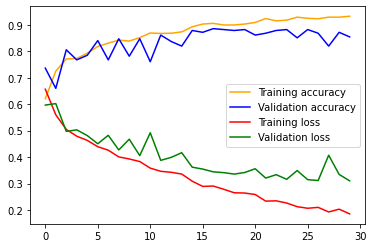

Path Test


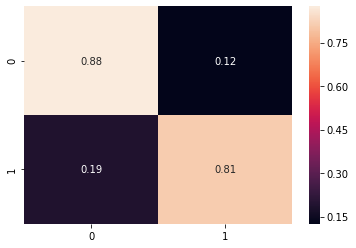

              precision    recall  f1-score   support

     Finding       0.76      0.88      0.81        64
      Normal       0.91      0.81      0.86        96

    accuracy                           0.84       160
   macro avg       0.83      0.84      0.83       160
weighted avg       0.85      0.84      0.84       160

Path Validate


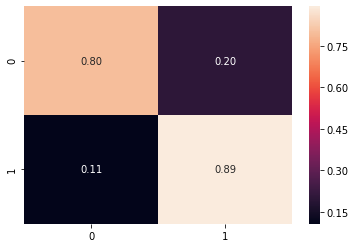

              precision    recall  f1-score   support

     Finding       0.84      0.80      0.82       120
      Normal       0.86      0.89      0.88       168

    accuracy                           0.85       288
   macro avg       0.85      0.85      0.85       288
weighted avg       0.85      0.85      0.85       288

INFO:tensorflow:Assets written to: model\extra\vgg16\Extra_0\assets
number of sample Train: 1152
number of sample Test: 160
number of sample Val: 288
Average test accuracy:  0.86229736
Average test loss:  0.34132472451396845


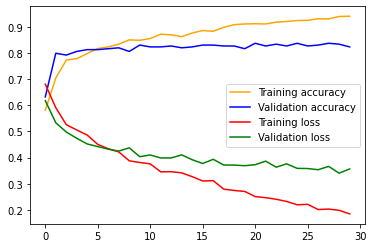

Path Test


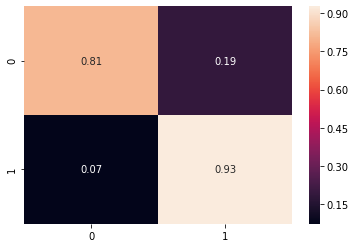

              precision    recall  f1-score   support

     Finding       0.88      0.81      0.85        64
      Normal       0.88      0.93      0.90        96

    accuracy                           0.88       160
   macro avg       0.88      0.87      0.87       160
weighted avg       0.88      0.88      0.88       160

Path Validate


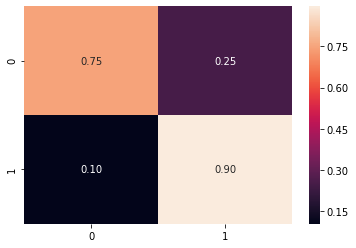

              precision    recall  f1-score   support

     Finding       0.88      0.75      0.81       144
      Normal       0.78      0.90      0.83       144

    accuracy                           0.82       288
   macro avg       0.83      0.82      0.82       288
weighted avg       0.83      0.82      0.82       288

INFO:tensorflow:Assets written to: model\extra\vgg16\Extra_1\assets
number of sample Train: 1152
number of sample Test: 160
number of sample Val: 288
Average test accuracy:  0.8540509
Average test loss:  0.35466176167785846


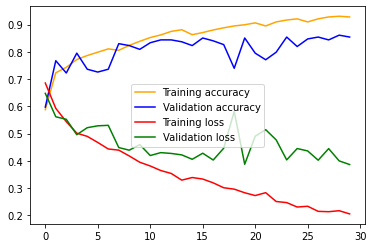

Path Test


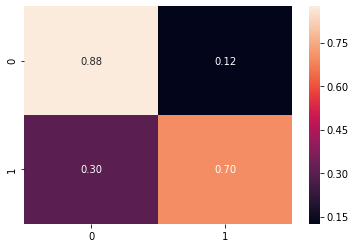

              precision    recall  f1-score   support

     Finding       0.66      0.88      0.75        64
      Normal       0.89      0.70      0.78        96

    accuracy                           0.77       160
   macro avg       0.78      0.79      0.77       160
weighted avg       0.80      0.77      0.77       160

Path Validate


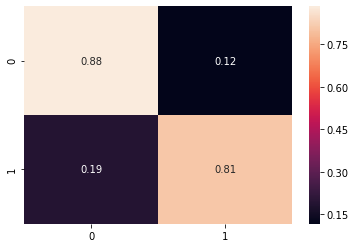

              precision    recall  f1-score   support

     Finding       0.87      0.88      0.88       172
      Normal       0.82      0.81      0.82       116

    accuracy                           0.85       288
   macro avg       0.85      0.85      0.85       288
weighted avg       0.85      0.85      0.85       288

INFO:tensorflow:Assets written to: model\extra\vgg16\Extra_2\assets
number of sample Train: 1152
number of sample Test: 160
number of sample Val: 288
Average test accuracy:  0.8471932
Average test loss:  0.36570981889618215


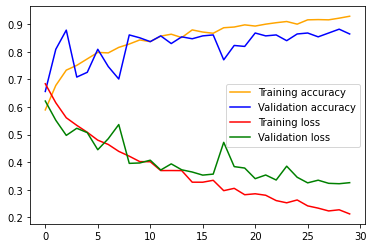

Path Test


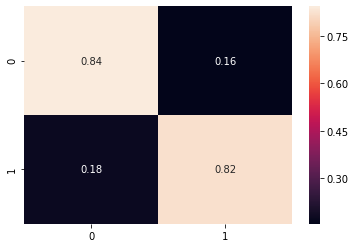

              precision    recall  f1-score   support

     Finding       0.76      0.84      0.80        64
      Normal       0.89      0.82      0.85        96

    accuracy                           0.83       160
   macro avg       0.82      0.83      0.83       160
weighted avg       0.84      0.83      0.83       160

Path Validate


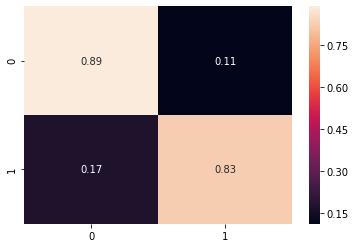

              precision    recall  f1-score   support

     Finding       0.88      0.89      0.89       172
      Normal       0.83      0.83      0.83       116

    accuracy                           0.86       288
   macro avg       0.86      0.86      0.86       288
weighted avg       0.86      0.86      0.86       288

INFO:tensorflow:Assets written to: model\extra\vgg16\Extra_3\assets
number of sample Train: 1152
number of sample Test: 160
number of sample Val: 288
Average test accuracy:  0.8654514
Average test loss:  0.32688428858571034


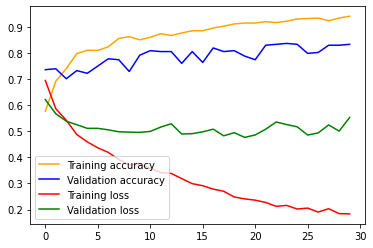

Path Test


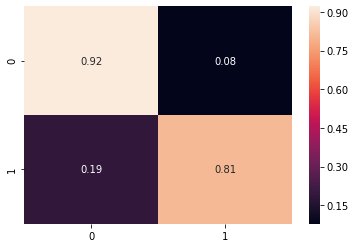

              precision    recall  f1-score   support

     Finding       0.77      0.92      0.84        64
      Normal       0.94      0.81      0.87        96

    accuracy                           0.86       160
   macro avg       0.85      0.87      0.85       160
weighted avg       0.87      0.86      0.86       160

Path Validate


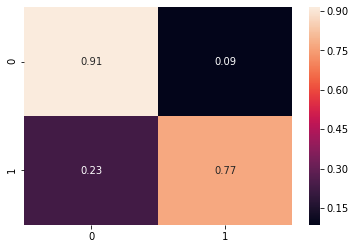

              precision    recall  f1-score   support

     Finding       0.76      0.91      0.83       128
      Normal       0.92      0.77      0.84       160

    accuracy                           0.83       288
   macro avg       0.84      0.84      0.83       288
weighted avg       0.85      0.83      0.83       288

INFO:tensorflow:Assets written to: model\extra\vgg16\Extra_4\assets
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


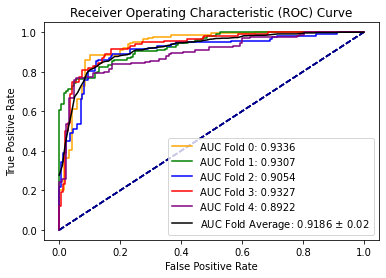

In [33]:
idk(disease_images, normal_images,"Extra")

In [25]:
from sklearn.model_selection import KFold
def vgg_19(other, normal,text) :
    k = 0
    # set to 5 folds
    box_tpr = []
    box_fpr = []
    box_acc = []
    #Set Test
    data = []
    label = []
    index = 0
    for i in range(5):
        for count in range(int(normal.shape[0]/5)):
            data.append(normal[index+count])
            label.append(1)
#             print(index+count)
        for count in range(int(other.shape[0]/5)):
            data.append(other[index+count])
            label.append(0)
        index+=int(normal.shape[0]/5)
    data = np.array(data)
    label = np.array(label)
    train_data, X_test, label_train, y_test = train_test_split(data, label, test_size=0.1)
    X_test_n, y_test_n = incre(X_test,y_test)
    n_classes = 2
    y_test_n = keras.utils.to_categorical(y_test_n, n_classes)
    kf = KFold(n_splits=5)
    for train, val in kf.split(train_data):
        X_train = train_data[train]
        X_val = train_data[val]
        y_train = label_train[train]
        y_val = label_train[val]
        
        X_train_n, y_train_n = incre(X_train,y_train)
        X_val_n, y_val_n = incre(X_val,y_val)
        #class
        y_train_n = keras.utils.to_categorical(y_train_n, n_classes)
        y_val_n = keras.utils.to_categorical(y_val_n, n_classes)
#         print(y_test)
        
        print("number of sample Train: {}".format(len(X_train_n)))
        print("number of sample Test: {}".format(len(X_test_n)))
        print("number of sample Val: {}".format(len(X_val_n)))
        
        
        recv_fpr,recv_tpr,recv_acc = vgg19_model(X_train_n,y_train_n,X_test_n,y_test_n,X_val_n,y_val_n,k,text)
        box_fpr.append(recv_fpr)
        box_tpr.append(recv_tpr)
        box_acc.append(recv_acc)
        k += 1
        
        #only one round
#         if k == 1: break
        
    # ROC
    roc(box_fpr,box_tpr,box_acc,k)

number of sample Train: 1152
number of sample Test: 160
number of sample Val: 288
Average test accuracy:  0.840133
Average test loss:  0.3694238351106092


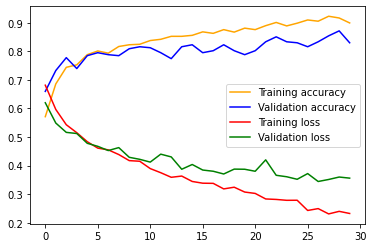

Path Test


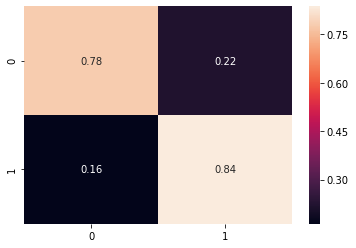

              precision    recall  f1-score   support

     Finding       0.78      0.78      0.78        68
      Normal       0.84      0.84      0.84        92

    accuracy                           0.81       160
   macro avg       0.81      0.81      0.81       160
weighted avg       0.81      0.81      0.81       160

Path Validate


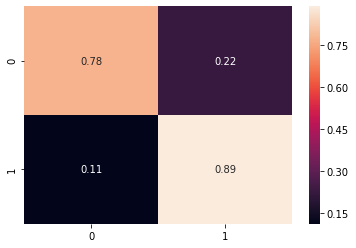

              precision    recall  f1-score   support

     Finding       0.89      0.78      0.83       152
      Normal       0.78      0.89      0.83       136

    accuracy                           0.83       288
   macro avg       0.83      0.83      0.83       288
weighted avg       0.84      0.83      0.83       288

INFO:tensorflow:Assets written to: model\extra\vgg19\Extra_0\assets
number of sample Train: 1152
number of sample Test: 160
number of sample Val: 288
Average test accuracy:  0.8451388
Average test loss:  0.3607545053224183


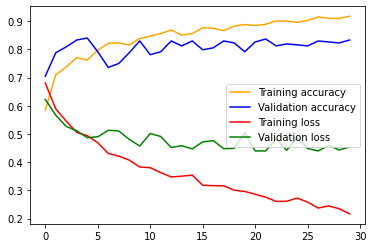

Path Test


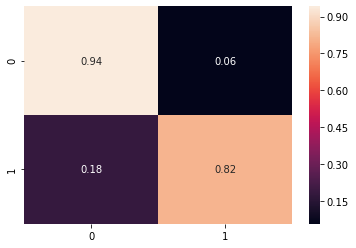

              precision    recall  f1-score   support

     Finding       0.79      0.94      0.86        68
      Normal       0.95      0.82      0.88        92

    accuracy                           0.87       160
   macro avg       0.87      0.88      0.87       160
weighted avg       0.88      0.87      0.87       160

Path Validate


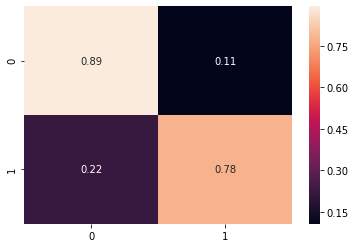

              precision    recall  f1-score   support

     Finding       0.79      0.89      0.84       140
      Normal       0.88      0.78      0.83       148

    accuracy                           0.83       288
   macro avg       0.84      0.83      0.83       288
weighted avg       0.84      0.83      0.83       288

INFO:tensorflow:Assets written to: model\extra\vgg19\Extra_1\assets
number of sample Train: 1152
number of sample Test: 160
number of sample Val: 288
Average test accuracy:  0.834375
Average test loss:  0.3793261228232748


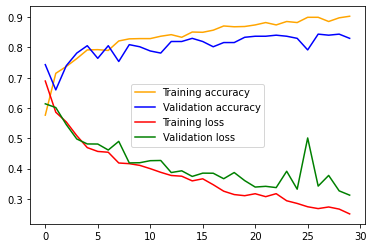

Path Test


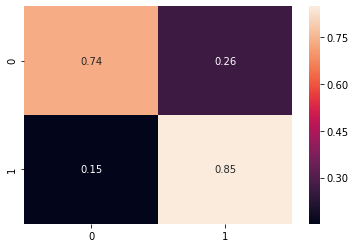

              precision    recall  f1-score   support

     Finding       0.78      0.74      0.76        68
      Normal       0.81      0.85      0.83        92

    accuracy                           0.80       160
   macro avg       0.80      0.79      0.79       160
weighted avg       0.80      0.80      0.80       160

Path Validate


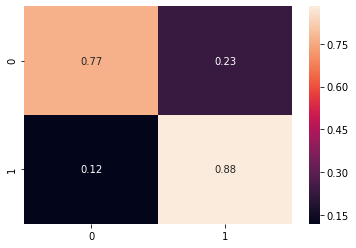

              precision    recall  f1-score   support

     Finding       0.84      0.77      0.80       128
      Normal       0.82      0.88      0.85       160

    accuracy                           0.83       288
   macro avg       0.83      0.82      0.83       288
weighted avg       0.83      0.83      0.83       288

INFO:tensorflow:Assets written to: model\extra\vgg19\Extra_2\assets
number of sample Train: 1152
number of sample Test: 160
number of sample Val: 288
Average test accuracy:  0.8410591
Average test loss:  0.37010083196305293


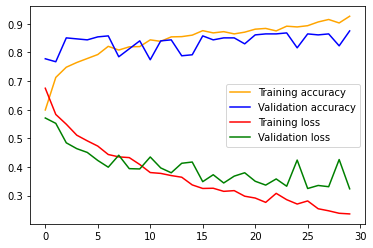

Path Test


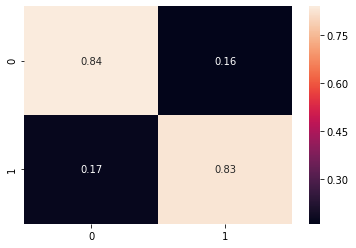

              precision    recall  f1-score   support

     Finding       0.78      0.84      0.81        68
      Normal       0.87      0.83      0.85        92

    accuracy                           0.83       160
   macro avg       0.83      0.83      0.83       160
weighted avg       0.83      0.83      0.83       160

Path Validate


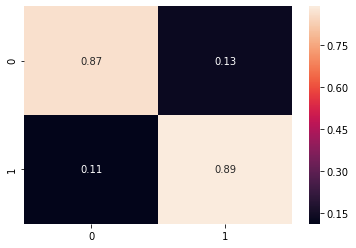

              precision    recall  f1-score   support

     Finding       0.91      0.87      0.89       164
      Normal       0.83      0.89      0.86       124

    accuracy                           0.88       288
   macro avg       0.87      0.88      0.87       288
weighted avg       0.88      0.88      0.88       288

INFO:tensorflow:Assets written to: model\extra\vgg19\Extra_3\assets
number of sample Train: 1152
number of sample Test: 160
number of sample Val: 288
Average test accuracy:  0.81875014
Average test loss:  0.4098577546749126


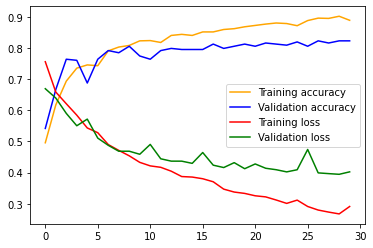

Path Test


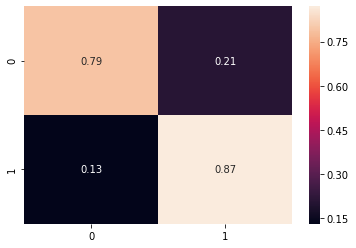

              precision    recall  f1-score   support

     Finding       0.82      0.79      0.81        68
      Normal       0.85      0.87      0.86        92

    accuracy                           0.84       160
   macro avg       0.83      0.83      0.83       160
weighted avg       0.84      0.84      0.84       160

Path Validate


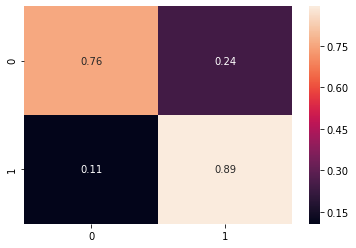

              precision    recall  f1-score   support

     Finding       0.88      0.76      0.81       148
      Normal       0.78      0.89      0.83       140

    accuracy                           0.82       288
   macro avg       0.83      0.82      0.82       288
weighted avg       0.83      0.82      0.82       288

INFO:tensorflow:Assets written to: model\extra\vgg19\Extra_4\assets
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


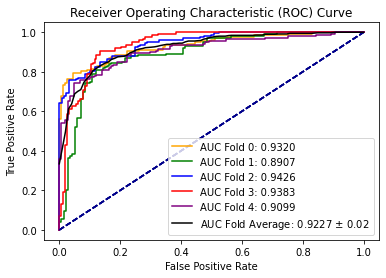

In [26]:
vgg_19(disease_images, normal_images,"Extra")